<div class="alert alert-block alert-info">
<b>Deadline:</b> January 29, 2025 (Wednesday) 23:00
</div>

# Exercise 2. Recommender system

In this exercise, your task is to design a recommender system.

## Learning goals:
* Practise tuning a neural network model by using different regularization methods.

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tools
import data

In [8]:
from torch.utils.data import DataLoader

In [9]:
skip_training = True  # Set this flag to True before validation and submission

In [10]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [11]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [12]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [13]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Ratings dataset

We will train the recommender system on the dataset in which element consists of three values:
* `user_id` - id of the user (the smallest user id is 1)
* `item_id` - id of the item (the smallest item id is 1)
* `rating` - rating given by the user to the item (ratings are integer numbers between 1 and 5).

The recommender system need to predict the rating for any given pair of `user_id` and `item_id`.

We measure the quality of the predicted ratings using the mean-squared error (MSE) loss:
$$
  \frac{1}{N}\sum_{i=1}^N (r_i - \hat{r}_i)^2
$$
where $r_i$ is a real rating and $\hat{r}_i$ is a predicted one.

Note: The predicted rating $\hat{r}_i$ does not have to be an integer number.

In [14]:
trainset = data.RatingsData(root=data_dir, train=True)
testset = data.RatingsData(root=data_dir, train=False)

In [15]:
# Print one sample from the dataset
x = trainset[0]
print(f'user_id={x[0]}, item_id={x[1]}, rating={x[2]}')


user_id=1, item_id=1, rating=5


# Model

You need to design a recommender system model with the API described in the cell below.

Hints on the model architecture:
* You need to use [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding) layer to convert inputs `user_ids` and `item_ids` into reasonable representations. The idea of the embedding layer is that we want to represent similar users with values that are close to each other. The original representation as integers is not good for that. By using the embedding layer, we can learn such useful representations automatically.

### Model tuning

In this exercise, you need to tune the architecture of your model to achieve the best performance on the provided test set. You will notice that overfitting is a severe problem for this data: The model can easily overfit the training set producing poor accuracy on the out-of-training (test) data.

You need to find an optimal combination of the hyperparameters, with some hyperparameters corresponding to the regularization techniques that we studied in the lecture.

The hyperparameters that you are advised to consider:
* Learning rate value and learning rate schedule (decresing the learning rate often has positive effect on the model performance)
* Number of training epochs
* Network size
* Weight decay
* Early stopping
* Dropout
* Increase amount of data:
  * Data augmentation
  * Injecting noise

You can tune the hyperparameters by, for example, grid search, random search or manual tuning. In that case, you can use `architecture` argument to specify the hyperparameters that define the architecture of your network. After you have tuned the hyperparameters, set the default value of this argument to the optimal set of the hyparameters so that the best architecture is used in the accuracy tests.

Note:
* The number of points that you will get from this exercise depends on the MSE loss on the test set:
  * below 1.00: 1 point
  * below 0.95: 2 points
  * below 0.92: 3 points
  * below 0.90: 4 points
  * below 0.89: 5 points
  * below 0.88: 6 points 

In [16]:
class RecommenderSystem(nn.Module):
    def __init__(self, n_users, n_items,
                 architecture=None  # If you want to tune the hyperparameters automatically (e.g. using random
                                    # search), use this argument to specify the hyperparameters that define the
                                    # architecture of your network. After you have tuned the hyperparameters,
                                    # set the default value of this argument to the optimal set of the hyparameters
                                    # so that the best architecture is used in the accuracy tests.
                ):
        """
        Args:
          n_users: Number of users.
          n_items: Number of items.
        """
        # YOUR CODE HERE
        super().__init__()
        self.emb_user = nn.Embedding(n_users, 1024)
        self.emb_item = nn.Embedding(n_items, 1024)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        #raise NotImplementedError()

    def forward(self, user_ids, item_ids):
        """
        Args:
          user_ids of shape (batch_size): User ids (starting from 1).
          item_ids of shape (batch_size): Item ids (starting from 1).

        Returns:
          outputs of shape (batch_size): Predictions of ratings.
        """
        # YOUR CODE HERE
        # nn.Embeddings requires user_ids and item_ids to start from 0
        user_ids = user_ids -1
        item_ids = item_ids - 1
        
        user = self.emb_user(user_ids)
        item = self.emb_item(item_ids)
        
        user = self.relu(self.fc1(user))
        user = self.dropout(user)
        user = self.relu(self.fc2(user))

        item = self.relu(self.fc1(item))
        item = self.dropout(item)
        item = self.relu(self.fc2(item))

        return (user*item).sum(dim=1)


You can test the shapes of the model outputs using the function below.

In [17]:
def test_RecommenderSystem_shapes():
    n_users, n_items = 100, 1000
    model = RecommenderSystem(n_users, n_items)
    batch_size = 10
    user_ids = torch.arange(1, batch_size+1)
    item_ids = torch.arange(1, batch_size+1)
    output = model(user_ids, item_ids)
    print(output.shape)
    assert output.shape == torch.Size([batch_size]), "Wrong output shape."
    print('Success')

test_RecommenderSystem_shapes()

torch.Size([10])
Success


In [429]:
# This cell is reserved for testing

## Train the model

You need to train a recommender system using **only the training data.** Please use the test set to select the best model: the model that generalizes best to out-of-training data.

**IMPORTANT**:
* During testing, the predictions are produced by `predictions = model(user_ids, item_ids)` with the `user_ids` and `item_ids` loaded from `RatingsData`.
* There is a size limit of 30Mb for saved models.

In [442]:
# Create the model
# IMPORTANT: the default value of the architecture argument should define your best model.
model = RecommenderSystem(trainset.n_users, trainset.n_items)

In [443]:
batch_size = 256
train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(testset, batch_size = batch_size, shuffle = True)

In [444]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience

    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.

        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).

                 Otherwise, False.
        """
        if len(val_errors) <= self.patience:
            return False

        min_val_error = min(val_errors)
        val_errors = np.array(val_errors[-self.patience:])
        return all(val_errors > min_val_error + self.tolerance)

In [445]:
# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.05, threshold = 0.01)
    
    early_stop = EarlyStopping(tolerance=0.01, patience=7)

    criterion = nn.MSELoss()
    epochs = 30
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        print(f"Epoch {epoch+1}")
        for user, item, rating in train_loader:
            optimizer.zero_grad()
            #output = model(trainset[:][0], trainset[:][1])
            
            output = model(user, item)
            loss = criterion(output, rating.float())
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        
        epoch_loss = epoch_loss/len(train_loader)
        
        train_loss.append(epoch_loss)
        print(f"Training loss : {epoch_loss:.4f}")
        
        epoch_loss = 0
        model.eval()

        with torch.no_grad():  # Disable gradient computation
            for user, item, rating in test_loader:  # Iterate over batches
                output = model(user, item)
                loss = criterion(output, rating.float())
                epoch_loss += loss.item()
            
        epoch_loss = epoch_loss/len(test_loader)
        test_loss.append(epoch_loss)
        if early_stop.stop_criterion(test_loss):
            print('Stop after %d epochs' % epoch)
            break
        scheduler.step(epoch_loss)
        
        print(f"Testing loss : {epoch_loss:.4f}")
        
            
        
    #raise NotImplementedError()

Epoch 1
Training loss : 1.3593
Testing loss : 1.0878
Epoch 2
Training loss : 1.0477
Testing loss : 1.0291
Epoch 3
Training loss : 0.9703
Testing loss : 1.0161
Epoch 4
Training loss : 0.9100
Testing loss : 0.9582
Epoch 5
Training loss : 0.8842
Testing loss : 0.9538
Epoch 6
Training loss : 0.8731
Testing loss : 0.9384
Epoch 7
Training loss : 0.8794
Testing loss : 0.9356
Epoch 8
Training loss : 0.8874
Testing loss : 0.9248
Epoch 9
Training loss : 0.8977
Testing loss : 0.9280
Epoch 10
Training loss : 0.9080
Testing loss : 0.9245
Epoch 11
Training loss : 0.9128
Testing loss : 0.9309
Epoch 12
Training loss : 0.9211
Testing loss : 0.9341
Epoch 13
Training loss : 0.9257
Testing loss : 0.9263
Epoch 14
Training loss : 0.9194
Testing loss : 0.9171
Epoch 15
Training loss : 0.8552
Testing loss : 0.8789
Epoch 16
Training loss : 0.8254
Testing loss : 0.8651
Epoch 17
Training loss : 0.8119
Testing loss : 0.8579
Epoch 18
Training loss : 0.8034
Testing loss : 0.8523
Epoch 19
Training loss : 0.7986
Testi

In [457]:
if not skip_training:
    criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        output = model(testset[:][0], testset[:][1])
        loss = criterion(output, testset[:][2].float())
    print(f"MSE test loss is {loss:.4f}")

MSE test loss is 0.8434


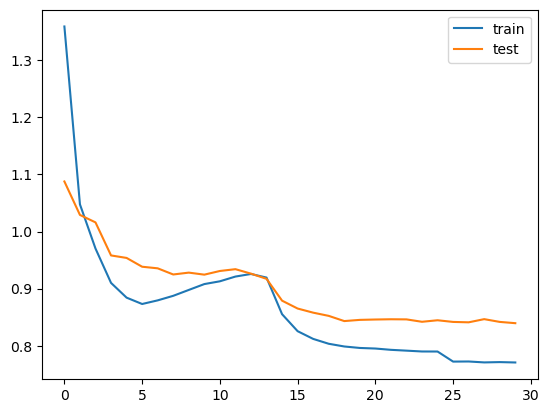

In [449]:
if not skip_training:
    plt.plot(train_loss, label = 'train')
    plt.plot(test_loss, label = 'test')
    plt.legend()

In [451]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(model, 'recsys.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to recsys.pth.


In [18]:
# This cell loads your best model
if skip_training:
    model = RecommenderSystem(trainset.n_users, trainset.n_items)
    tools.load_model(model, 'recsys.pth', device)

Model loaded from recsys.pth.


The next cell tests the accuracy of your best model. It is enough to submit .pth files.

**IMPORTANT**:
* During testing, the predictions are produced by `predictions = model(user_ids, item_ids)` with the `user_ids` and `item_ids` loaded from `RatingsData`.
* There is a size limit of 30Mb for saved models. Please make sure that your model loads in the cell above.

In [ ]:
# This cell tests the accuracy of your best model.

In [ ]:
# This cell is reserved for grading

In [ ]:
# This cell is reserved for grading

In [ ]:
# This cell is reserved for grading

In [ ]:
# This cell is reserved for grading

In [ ]:
# This cell is reserved for grading

In [ ]:
# This cell is reserved for grading